# Regressão Logística usando Softmax no Keras - Iris dataset

Este notebook procura reproduzir o exemplo de Regressão Logística usando Softmax,
já feito utilizando programação matricial. 
Neste notebook utiliza-se o Keras, utilizando o mesmo modelo e mesmos parâmetros

<img src="../figures/LearningRate.png",width=300>

In [1]:
import numpy as np
import sys,os
sys.path.append(os.path.abspath('../src/')) # para importar my_keras_utilities

import keras
import matplotlib.pyplot as plt
%matplotlib inline

#from my_keras_utilities import (load_model_and_history, 
#                                save_model_and_history, 
#                                TrainingPlotter)
from my_keras_utilities import TrainingPlotter


Using Theano backend.


## Getting the data
Keras also offers a collection of datasets that can be used to train and test the model. The MNIST set is a part of the available datasets and can be loaded as shown below.

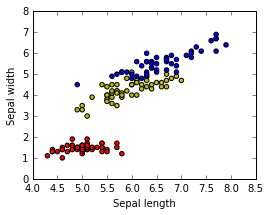

In [2]:
from sklearn import linear_model, datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:,::2]  # we only take the first two features: length and width of the sepals
Y = iris.target

plt.figure(1, figsize=(4, 3))
colors = np.array(['r','y','b'])
plt.scatter(X[:, 0], X[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()



## Normalização das amostras

Este passo é crucial para convergência no treinamento.

[[ 5.1  1.4]
 [ 4.9  1.4]
 [ 4.7  1.3]
 [ 4.6  1.5]
 [ 5.   1.4]
 [ 5.4  1.7]
 [ 4.6  1.4]
 [ 5.   1.5]
 [ 4.4  1.4]
 [ 4.9  1.5]]
[[ 4.3  1. ]]
[[ 0.8  0.4]
 [ 0.6  0.4]
 [ 0.4  0.3]
 [ 0.3  0.5]
 [ 0.7  0.4]
 [ 1.1  0.7]
 [ 0.3  0.4]
 [ 0.7  0.5]
 [ 0.1  0.4]
 [ 0.6  0.5]]


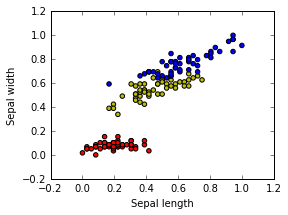

In [3]:
print X[:10,:]
xx = X.min( axis = 0, keepdims=True)
print xx[:10,:]
X -= xx
print X[:10,:]
X /= X.max( axis = 0, keepdims=True)

plt.figure(1, figsize=(4, 3))
colors = np.array(['r','y','b'])
plt.scatter(X[:, 0], X[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()


## Embaralhamento das amostras

O embaralhamento das amostras de treinamento é importante em dois casos:
quando se for usar o SGD onde o minibatch precisa ser representativo da
amostra e quando o treinamento utilizar parte das amostras para validação.
É usual passar como parâmetro a percentagem de amostras de treinamento
que serão utilizadas para validação. Este é o caso neste exercício.

A seguir, iremos detalhar como se faz um embaralhamento das amostras. Observe
que é necessário embaralhar tanto o vetor de rótulos `Y` como o array de amostras `X`.

Primeiro vamos observar que as amostras estão ordenadas.
Primeiro aparecem as amostras de rótulo 0, depois todas com rótulo 1 e por último
as de rótulo 2

In [4]:
print Y

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Uma das técnicas eficientes para se fazer isso, é criar um vetor índice
sequencial mas aleatório. Isto é feito pela função `permutation` onde se
passa o tamanho do vetor de índice.

**Dica:** Para que o gerador pseudoaleatório gere sempre a mesma sequência, utiliza-se
a mesma semente para o gerador. Isto simplifica o momento de depuração do
seu notebook, pois os dados serão exatamente o mesmo em cada execução.

In [5]:
np.random.seed(4)
p = np.random.permutation(Y.size)
print p


[128  18 130 105 107  78  83  14   5 133  25  11  12  63 113  34  60   2
  24 123  35 124  68  26  29  19  41  16  20 101  84  47 108   1  93 144
 125  92  86  46 135   7  65  10 132  13  15  61  91 116  27  69 118 136
  97  96  43  64 119  90   6  88  39  74 112  77 110  85   9 106 120  31
  80 100   4 127  54 149  72  37 134  51 102  36 111  53 139  82 142  71
  70 148  99  75 114  62  67  22 140  23  76  48  59  73  89  81  17 145
 138  95  98  79   3  28 141 121  33  45  42 115  40  32 146 143  66  49
   8  30 117  56  21   0 131  52 126  38  44 147  57  55  94 109 103  58
 137  50  87 104 129 122]


Utiliza-se o vetor de índice aleatório para indexar tanto o vetor de rótulos `Y`
como o array `X` das amostras. É necessário indexar apenas as linhas de `X`
pois cada amostra possui seus atributos armazenadas nas linhas:

In [6]:
X = X[p,:]
Y = Y[p]

#X = np.vstack([X,X])
#Y = np.hstack([Y,Y])
print X.shape
print Y.shape


(150, 2)
(150,)


## Divisão entre dados de treinamento e de validação

O treinamento é feito em cima dos dados de treinamento e uma parte é separada para
validação. No caso iremos utilizar 0.33 dos dados como validação. É importante que
os dados de validação tenham a mesma distribuição estatística dos dados de treinamento.

Como ilustração, vamos visualizar os dados de treinamento e os dados de validação:

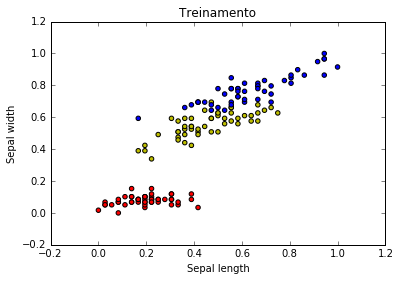

In [7]:
n = X.shape[0]
colors = np.array(['r','y','b'])
plt.scatter(X[:, 0], X[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Treinamento')

#plt.show()


# Converter vetores de rótulos em vetores one-hot

In [8]:
from keras.utils import np_utils 
Y_oh = np_utils.to_categorical(Y, 3) 
print Y[0:5]
print Y_oh[0:5]

[2 0 2 2 2]
[[ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


# Build the model

In [9]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.regularizers import l2
output_dim = nb_classes = 3 
model = Sequential() 
model.add(Dense(3, input_dim=2, activation='relu',init='uniform'))
#model.add(Dropout(0.5))
model.add(Dense(output_dim, activation='softmax',init='uniform')) 
batch_size = 100
nb_epoch = 200

# Compile and train the model



loss: [0.20865188380082447, 0.94666667064030963]


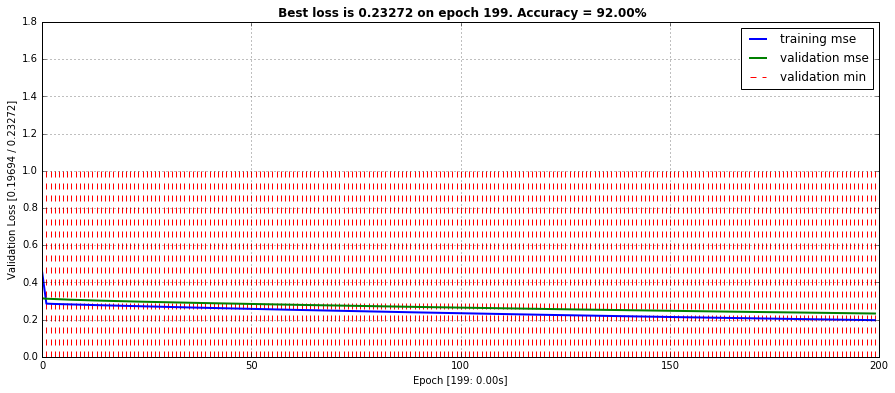

In [18]:
my_big_callback = TrainingPlotter(n=1, patience=10)

sgd = SGD(lr= 0.5, decay=0e-6, momentum=0., nesterov=False)
model.compile(optimizer=sgd , loss='categorical_crossentropy', metrics=['accuracy']) 
#model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy']) 

ploss = 1.8

fig = plt.figure(figsize=(15,6))
plt.ylim(0.0, ploss)
plt.xlim(0, nb_epoch)
plt.grid(True)

print("[INFO] training...")
try:
    history = model.fit(X, Y_oh, batch_size=batch_size, nb_epoch=nb_epoch,verbose=0,
                       validation_split=0.33, callbacks=[my_big_callback])
    #histo2 = model.fit(X_train, y_train, batch_size=128, nb_epoch=nepochs, 
    #                   verbose=0, validation_split=0.33, callbacks=[my_big_callback])
except KeyboardInterrupt:
    pass

loss = model.evaluate(X, Y_oh, verbose=0)
#print history.history
print 'loss:',loss


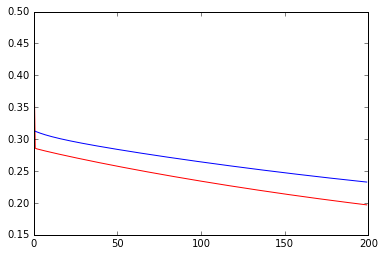

In [19]:
i = np.arange(len(history.history['loss']))
plt.plot(i,history.history['loss'],'r', i, history.history['val_loss'],'b')

In [20]:
W = model.get_weights()
print W

[array([[-0.181261  , -0.01525487, -0.04089344],
       [ 5.56827021, -0.03759854,  0.08075215]], dtype=float32), array([-1.38819897,  0.        , -0.02343884], dtype=float32), array([[ -4.44421005e+00,   7.70338178e-01,   3.73855758e+00],
       [ -3.26220207e-02,   4.42585833e-02,  -3.45103256e-03],
       [  1.86190121e-02,  -1.32278446e-02,   9.43111852e-02]], dtype=float32), array([ 4.14131308,  1.0991385 , -5.24045134], dtype=float32)]


In [21]:
def getAccuracy(X,Y):
    Y_hat = model.predict_classes(X)
    print '\nY_hat:', Y_hat[:5]
    accuracy = sum(Y_hat == Y)/(float(len(Y)))
    return accuracy

train_ac = getAccuracy(X,Y)
print 
print 'Training Accuracy: ', train_ac


 32/150 [=====>........................] - ETA: 0s
Y_hat: [2 0 2 2 2]

Training Accuracy:  0.946666666667


 8736/10000 [=========================>....] - ETA: 0s

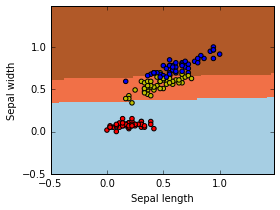

In [22]:

h = .02  # step size in the mesh

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
colors = np.array(['r','y','b'])
plt.scatter(X[:, 0], X[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

## Perguntas e exercícios

1. Às vezes, durante o treinamento, observamos que a acurácia já está em 100%, porém a perda
   ainda está diminuindo
   
2. Modificar o callback para visualizar o espaço de atributos durante o treinamento

3. Efeito na taxa de aprendizagem

4. Efeito na normalização dos dados

5. Efeito na inicialização dos pesos

6. Efeito na escolha dos atributos. Para o caso deste Iris dataset, a escolha dos dois 
   primeiros atributos torna o problema muito mais difícil do que utilizr os dois últimos

## Conclusões desses experimentos

- Treinamento é a parte crítica de projetos com redes neurais e redes profundas
- Importância da escolha dos dados e sua quantidade
- Às vezes não se consegue colocar o sistema para permitir sua otimização. Ele fica
  parado num mínimo local
  
